<a href="https://colab.research.google.com/github/doowilliams/ideal-telegram/blob/main/LVC_BERT_and_its_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing and Loading Necessary Libraries

In [ ]:
# installing the libraries to load transformer models and datasets
!pip install --quiet transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00


In [ ]:
# importing library for mathematical computations
import numpy as np

# importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# importing the function to load the dataset
from datasets import load_dataset

# importing BERT-related components from the transformers library
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# importing library for deep learning
import tensorflow as tf

# importing evaluation metrics from scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

## Loading the Dataset

We'll use the [CoLA](https://www.kaggle.com/datasets/krazy47/cola-the-corpus-of-linguistic-acceptability) dataset.

- **CoLA** stands for **C**orpus **o**f **L**inguistic **A**cceptability
- It consists of 10657 sentences from 23 linguistics publications, expertly annotated for grammatical acceptability
- The target variables is a 'Yes' (1) or 'No' (0), indicating whether the sentence has acceptable grammar or not respectively

In [ ]:
# loading the cola dataset
dataset = load_dataset("glue", "cola")

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
# creating the train and validation splits
dataset_train = dataset["train"]
dataset_val = dataset["validation"]

## Data Overview

Let's see what the data actually contains.

In [ ]:
dataset_train

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

- The data contains sentences, their labels, and index values

In [ ]:
i = 0
print('Sentence:', dataset_train['sentence'][i])
print('Label:', dataset_train['label'][i])

Sentence: Our friends won't buy this analysis, let alone the next one we propose.
Label: 1


- This is a grammatically acceptable sentence

In [ ]:
i = 1000
print('Sentence:', dataset_train['sentence'][i])
print('Label:', dataset_train['label'][i])

Sentence: I read three his books.
Label: 0


- This is a grammatically unacceptable sentence

## Data Preprocessing

The data preprocessing step involve tokenizing the data.

- Tokenization is a fundamental step in preparing text data for machine learning models
- It allows them to effectively process and learn from textual information
- It facilitates the conversion of text into a format that can be easily fed into models, enabling them to understand and make predictions based on language patterns

In [ ]:
# creating an instance of BERT's tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

* `pretrained_model_name_or_path`: takes the name/path of the model for which tokenizer needs to be imported
    * We're passing '*bert-base-cased*' as we want to load BERT base model's tokenizer

* Both the BERT base and large models have two available variants

    * **uncased**: Preserves case information and may capture subtle nuances in meaning based on capitalization
    * **cased**: Ignores case and may not capture subtle meaning differences based on case

In [ ]:
# tokenizing the train dataset
tokenized_data_train = tokenizer(dataset_train["sentence"], return_tensors="tf", padding=True)

# converting the tokenized data into a dictionary
tokenized_data_train = dict(tokenized_data_train)

* The first argument to the tokenizer is a list of text
    * We convert the training text to a list and then pass it to the tokenizer

* `return_tensors`: Specifies what kind the output tensors should be of
    * "*tf*" means that the output tensors should be in a format suitable for tensorflow

* `padding`: A boolean argument that enables padding
    * *True* ensures padding is done

**Note**: Padding is the process of adding special tokens to sequences to make them of equal length.
* When the `padding` value is set to *True* during tokenization, the tokenizer automatically adds special tokens to shorter sequences in a batch, ensuring all sequences have the same length
* When set to *False*, sequences of varying lengths are not padded, and manual handling of variable-length sequences is required
    * This approach may introduce additional complexity in handling input data during training

In [ ]:
print(tokenized_data_train.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


* **input_ids**: This key contains the tokenized representation of the input text in the form of token IDs. Each token in the text is converted into a unique integer ID, and these IDs are stored in a sequence under the 'input_ids' key.

* **token_type_ids**: In the case of models that can handle multiple sequences (e.g., for tasks like question-answering where there are two input sequences - question and answer), this key represents the segment or token type IDs. It helps the model distinguish between different segments of the input.

* **attention_mask**: This key contains a binary mask indicating which positions in the input text are actual tokens as opposed to padding tokens. The attention mask is used to tell the model which tokens to pay attention to and which ones to ignore during processing.


**Note**: This 'attention' is not the same as the attention mechanism. This is just a flag to help the model understand which tokens do not carry any information.

In [ ]:
tokenized_data_train

{'input_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
 array([[ 101, 3458, 2053, ...,    0,    0,    0],
        [ 101, 1448, 1167, ...,    0,    0,    0],
        [ 101, 1448, 1167, ...,    0,    0,    0],
        ...,
        [ 101, 1135, 1110, ...,    0,    0,    0],
        [ 101,  146, 1125, ...,    0,    0,    0],
        [ 101, 1327, 1155, ...,    0,    0,    0]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

Let's check the original and tokenized sentences.

In [ ]:
i = 0
print(dataset_train['sentence'][i])

Our friends won't buy this analysis, let alone the next one we propose.


In [ ]:
tokenized_data_train['input_ids'][i]

<tf.Tensor: shape=(47,), dtype=int32, numpy=
array([  101,  3458,  2053,  1281,   112,   189,  4417,  1142,  3622,
         117,  1519,  2041,  1103,  1397,  1141,  1195, 17794,   119,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)>

In [ ]:
tokenized_data_train['attention_mask'][0]

<tf.Tensor: shape=(47,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)>

- The attention mask value is 1 for words in the sentence and 0 for padding values

In [ ]:
# tokenizing the train dataset
tokenized_data_val = tokenizer(dataset_val["sentence"], return_tensors="tf", padding=True)

# converting the tokenized data into a dictionary
tokenized_data_val = dict(tokenized_data_val)

In [ ]:
# converting target variables to numpy arrays
labels_train = np.array(dataset_train["label"])
labels_val = np.array(dataset_val["label"])

## Model Building

### Loading the base model

In [ ]:
# loading the model
bert_base = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path="bert-base-cased")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Note**: The message in the output is informing that while the main BERT model was loaded from the pre-trained weights successfully, the original weights of the *classifier* layer of the model was not loaded and was initialized randomly.
* To use the model effectively for specific task, we have to fine-tune it on our dataset

In [ ]:
bert_base.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* **TFBertMainLayer** (alias bert): This is the main BERT layer responsible for processing input sequences. It has ~110 million parameters, which are the
weights and biases that the model has learned during pre-training. This layer is designed to capture contextualized representations of input tokens

* **Dropout** (alias dropout_37): This layer applies dropout to the output of the BERT layer. Dropout is a regularization technique used to prevent overfitting. It has no parameters since dropout doesn't introduce new parameters

* **Dense** (alias classifier): This is the final dense layer responsible for the sequence classification. It has 1538 parameters, which are the weights and biases for mapping the BERT representation to the final output classes

### Fine-tuning the model

In [ ]:
bert_base.compile(optimizer=tf.keras.optimizers.Adam(5e-5), metrics=['accuracy'])

* `optimizer`: Specifies the optimizer to be used for training the model
    * 'We're using the Adam optimizer with a learning rate of 5e-5 (0.00005)

* `metrics`: Specifies the evaluation metric(s) to be monitored during training
    * '*accuracy*' specifies that the accuracy be monitored

In [ ]:
# training the model for 10 epochs
bert_base.fit(tokenized_data_train, labels_train, epochs=10)

Epoch 1/10
268/268 [==============================] - 139s 331ms/step - loss: 0.5590 - accuracy: 0.7272
Epoch 2/10
268/268 [==============================] - 85s 319ms/step - loss: 0.3726 - accuracy: 0.8440
Epoch 3/10
268/268 [==============================] - 88s 328ms/step - loss: 0.2099 - accuracy: 0.9219
Epoch 4/10
268/268 [==============================] - 86s 320ms/step - loss: 0.1431 - accuracy: 0.9502
Epoch 5/10
268/268 [==============================] - 84s 315ms/step - loss: 0.1040 - accuracy: 0.9648
Epoch 6/10
268/268 [==============================] - 84s 315ms/step - loss: 0.0842 - accuracy: 0.9729
Epoch 7/10
268/268 [==============================] - 84s 314ms/step - loss: 0.0726 - accuracy: 0.9774
Epoch 8/10
268/268 [==============================] - 84s 314ms/step - loss: 0.0482 - accuracy: 0.9839
Epoch 9/10
268/268 [==============================] - 84s 315ms/step - loss: 0.0516 - accuracy: 0.9848
Epoch 10/10
268/268 [==============================] - 84s 314ms/step - 

### Evaluating the model's performance

In [ ]:
# predicting using the loaded model
preds_raw_train = bert_base.predict(tokenized_data_train)

# converting logits to a probability distribution
# and then choosing the class with highest probability as the prediction
preds_train = np.argmax(np.array(tf.nn.softmax(preds_raw_train.logits)), axis=1)

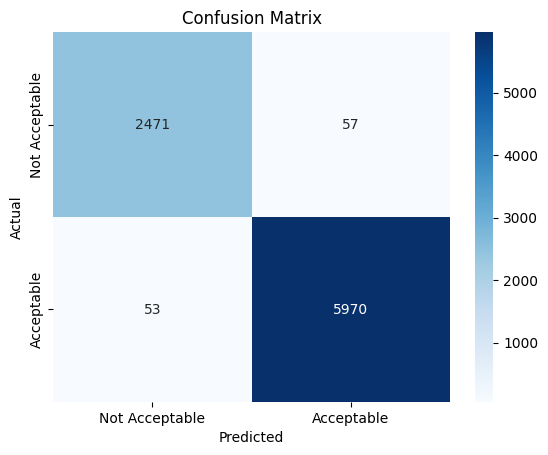

In [ ]:
# creating confusion matrix
cnf_mt_train = confusion_matrix(labels_train, preds_train)

# visualizing confusion matrix using a heatmap
labels = ['Not Acceptable', 'Acceptable']
sns.heatmap(cnf_mt_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# printing the classification report
print(classification_report(labels_train, preds_train))

In [ ]:
# predicting using the loaded model
preds_raw_val = bert_base.predict(tokenized_data_val)

# converting logits to a probability distribution
# and then choosing the class with highest probability as the prediction
preds_val = np.argmax(np.array(tf.nn.softmax(preds_raw_val.logits)), axis=1)

In [ ]:
# creating confusion matrix
cnf_mt_val = confusion_matrix(labels_val, preds_val)

# visualizing confusion matrix using a heatmap
labels = ['Not Acceptable', 'Acceptable']
sns.heatmap(cnf_mt_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# printing the classification report
print(classification_report(labels_val, preds_val))

## Summary

- We fine-tuned a BERT model to predict whether a sentence is grammatically correct or not

- We got an accuracy of ~99% on the training set and ~80% on the validation set

- The model is overfitting the training data

- To try to improve the model performance, one can try the following:
    - increase the number of training epochs
    - change the learning rate
    - change the batch size
    - use regularization techniques

**Note**: The performance metric values may differ slightly on code execution due to the randomness in initializing the weights of the 'classifier' layer of the model.

___